# LOGISTIC REGRESSION

We will try to apply the concepts learnt so far for a practical problem following the steps of a typical DataScience SDLC

<img src='Images/sdlc_step_1.JPG'/>

# Predict if a Customer will (1) or will not (0) purchase from us

We have the details of customers and we would like to predict based on existing customers if a new customer will buy (1) or will not buy (0) from us

In [1]:
# Importing the necessary Libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, itertools
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border: 1px solid lightgray;
    }
</style>

In [3]:
# Define Utiliy Functions
def data_insights_report(data=pd.DataFrame()):
    report = pd.DataFrame()
    report['Columns'] = data.columns
    report['Data_Types'] = data.dtypes.values
    report['Unique_Count'] = data.nunique().values
    report['NAN_Count'] = data.isna().sum().values

    tempdf = data.describe().apply(lambda x: round(x,2), axis=1).T
    pd.merge(report,tempdf.reset_index().rename(columns={'index':'Columns'}), on='Columns')

    return report.join(tempdf, on='Columns')

# Confustion Matrix Viz Function
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Purchased", "Not Purchased"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<img src='Images/sdlc_step_2.JPG'/>

# Importing the Data

In [4]:
sales_df = pd.read_csv('Social_Network_Ads.csv')    # Reading data from a CSV File
sales_df.head(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1
8,15600575,Male,25,33000,0
9,15727311,Female,35,65000,0


# Initial Data Insights Report

In [5]:
data_insights_report(sales_df)    # This report gives as view of the data, its metrics and basic actionable Insights

,Columns,Data_Types,Unique_Count,NAN_Count,count,mean,std,min,25%,50%,75%,max
0,User ID,int64,400,0,400.0,15691539.76,71658.32,15566689.0,15626763.75,15694341.5,15750363.0,15815236.0
1,Gender,object,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Age,int64,43,0,400.0,37.66,10.48,18.0,29.75,37.0,46.0,60.0
3,EstimatedSalary,int64,117,0,400.0,69742.50,34096.96,15000.0,43000.00,70000.0,88000.0,150000.0
4,Purchased,int64,2,0,400.0,0.36,0.48,0.0,0.00,0.0,1.0,1.0


# Data Visualisations

1> Purchase feature is a little skewed towards the not-purchased people but not at an alarming level.<br>
2> Gender representation is good and almost equal.<br>
3> For Age except for a spike near 20 year, we have a fair representative population for all ages in the age-range.<br>
4> Estimated salary vs Age show a fare amount of scatter.<br>

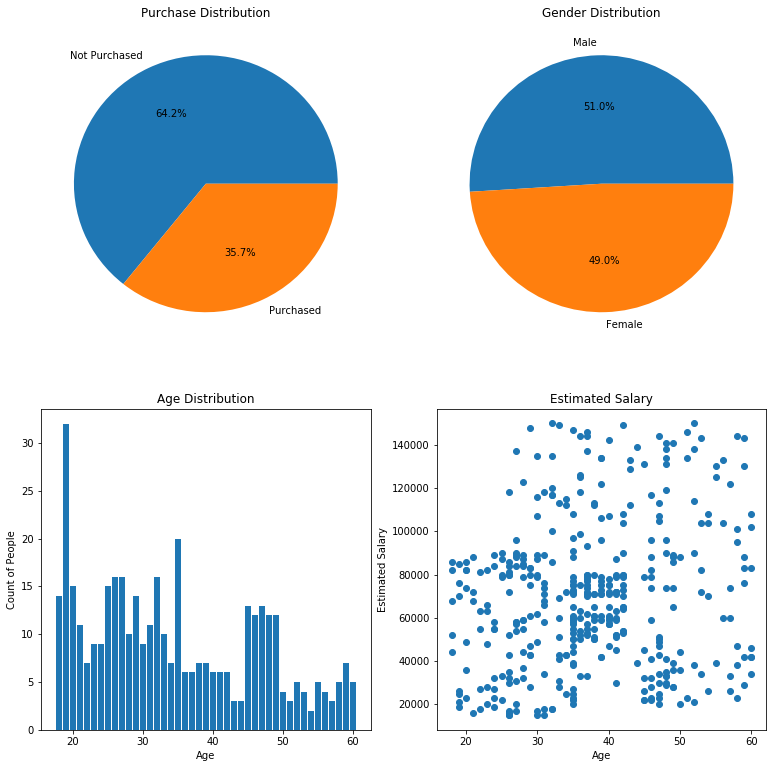

In [6]:
# Creating basic aggregation Visualisations
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 13))
ax[0,0].pie(sales_df.Purchased.value_counts().values, labels=['Not Purchased','Purchased'], startangle=0, autopct='%1.1f%%')
ax[0,0].title.set_text('Purchase Distribution')
ax[0,1].pie(sales_df.Gender.value_counts().values, labels=sales_df.Gender.unique(), startangle=0, autopct='%1.1f%%')
ax[0,1].title.set_text('Gender Distribution')
ax[1,0].bar(sales_df.Age.unique().tolist(), sales_df.Age.value_counts().values.tolist())
ax[1,0].title.set_text('Age Distribution')
ax[1,0].set_xlabel('Age')
ax[1,0].set_ylabel('Count of People')
ax[1,1].scatter(sales_df.Age.values, sales_df.EstimatedSalary.values)
ax[1,1].title.set_text('Estimated Salary')
ax[1,1].set_xlabel('Age')
ax[1,1].set_ylabel('Estimated Salary')
plt.show()

<img src='Images/sdlc_step_3.JPG'/>

# Preprocessing Data

1> Gender (character) features needs to be converted to numeric. Label Encoding/Dummy Encoding.<br>
2> The features are all at different scale. Scaling/Standardisation.<br>
3> Dividing the data into train and test split.

In [7]:
# Encoding the Text Columns numeric. This is done to convert text to numbers since Algorithms needs numbers.
labenc = LabelEncoder()
sales_df.Gender = labenc.fit_transform(sales_df.Gender)

# Standard Scaling of all numeric Predictors so each feature equally contributes the prediction algorithm
stdsclr = StandardScaler()
sales_df.iloc[:,1:-1] = stdsclr.fit_transform(sales_df.iloc[:, 1:-1])

sales_df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,1.020204,-1.781797,-1.490046,0
1,15810944,1.020204,-0.253587,-1.460681,0
2,15668575,-0.980196,-1.113206,-0.785290,0
3,15603246,-0.980196,-1.017692,-0.374182,0
4,15804002,1.020204,-1.781797,0.183751,0


# Feature Selection/Elimination

1> Plotting a Pearson Co-relation Matrix<br>

This plot helps us determine the correlations if any exists among the predictors. In case when there are 1000s of predictores it becomes necceary to reduce the data space. Also correlated features will all give same information and hence makes sense to eliminate all except anyone of the correlated features

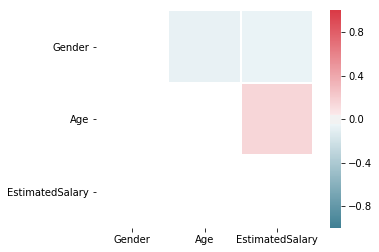

In [8]:
# Generate a mask for the upper triangle
mask = np.zeros_like(sales_df.iloc[:,1:-1].corr(method='pearson'), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(sales_df.iloc[:,1:-1].corr(method='pearson'), cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, mask=mask)

In [9]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(sales_df.iloc[:,1:-1], sales_df.iloc[:,-1], test_size=0.25)
print('Size of Train Data:', X_train.shape)
print('Size of Test Data:', X_test.shape)
X_train.head()

Size of Train Data: (300, 3)
Size of Test Data: (100, 3)


,Gender,Age,EstimatedSalary
156,1.020204,0.797057,-0.315452
223,1.020204,2.134241,0.947237
81,1.020204,0.128465,-0.814655
262,-0.980196,1.656675,1.622629
233,1.020204,1.083596,0.477399


<img src='Images/sdlc_step_4.JPG'/>

# Logistic Regression Model Fitting

In [12]:
model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
pred_df = pd.DataFrame({'User ID':sales_df[sales_df.index.isin(X_test.index.tolist())]['User ID'],
                      'Purchased Actual':sales_df[sales_df.index.isin(X_test.index.tolist())]['Purchased'],
                      'Purchased Prediction:':y_pred}).head(20)
pred_df.head(10)

,User ID,Purchased Actual,Purchased Prediction:
2,15668575,0,0
5,15728773,0,0
13,15704987,0,0
15,15697686,0,0
18,15704583,1,1
24,15705113,1,1
25,15631159,1,0
35,15713144,0,1
40,15764419,0,0
45,15639277,0,0


<img src='Images/sdlc_step_5.JPG'/>

# Model Metrics and Evaluations

,Metric,Score
0,Accuracy,0.780000
1,Precision,0.807692


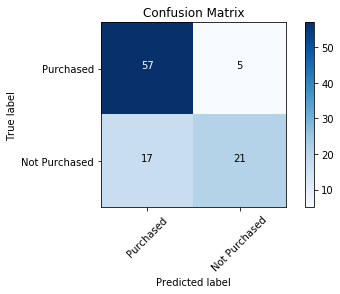

In [11]:
plot_confusion_matrix(y_pred, normalize=False)
pd.DataFrame({'Metric':['Accuracy','Precision'], 'Score':[accuracy_score(y_test,y_pred), precision_score(y_test,y_pred)]})

<img src='Images/sdlc_step_6.JPG'/>

<img src='Images/ThankYou_ML.jpg'/>